## Different Optimisers for SPMe Parameter Estimation

In this notebook, we demonstrate parameter estimation for a single-particle model for various PyBOP optimisers. PyBOP offers a variety of gradient and non-gradient based optimisers, with a table of the currently supported methods shown in the Readme. In this example, we will set up the model, problem, and cost function and investigate how the different optimisers perform under this task.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [1]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [2]:
import numpy as np

import pybop

## Generating Synthetic Data

To demonstrate the parameter estimation, we first need some data. We will generate synthetic data using a PyBOP DFN forward model, which requires defining a parameter set and the model itself.

### Defining Parameters and Model

We start by creating an example parameter set, constructing the DFN for synthetic generation, and the model we will be fitting (SPMe).

In [3]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
synth_model = pybop.lithium_ion.DFN(parameter_set=parameter_set)
model = pybop.lithium_ion.SPMe(parameter_set=parameter_set)

### Simulating the Forward Model

We can then simulate the model using the `predict` method, with a default constant current discharge to generate the voltage data.

In [4]:
t_eval = np.arange(0, 2000, 10)
init_soc = 1.0
values = synth_model.predict(t_eval=t_eval, init_soc=init_soc)

### Adding Noise to Voltage Data

To make the parameter estimation more realistic, we add Gaussian noise to the data.

In [5]:
sigma = 0.002
corrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(t_eval))

## Identifying the Parameters

We will now set up the parameter estimation process by defining the datasets for optimisation and selecting the model parameters we wish to estimate.

### Creating a Dataset

The dataset for optimisation is composed of time, current, and the noisy voltage data:

In [6]:
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

### Defining Parameters to Estimate

We select the parameters for estimation and set up their prior distributions and bounds. In this example, non-geometric parameters for each electrode's active material volume fraction are selected.

In [7]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.6, 0.02),
        bounds=[0.5, 0.8],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.48, 0.02),
        bounds=[0.4, 0.7],
    ),
)

### Selecting the Optimisers

Now, we can select the optimisers to investigate. The first object is a list of non-gradient-based PINTS's optimisers. The next object comprises the gradient-based PINTS's optimisers (AdamW, GradientDescent, IRPropMin). The final object forms the SciPy optimisers which can have gradient and non-gradient-based algorithms.

In [8]:
gradient_optimisers = [
    pybop.AdamW,
    pybop.GradientDescent,
    pybop.IRPropMin,
]

non_gradient_optimisers = [
    pybop.CMAES,
    pybop.SNES,
    pybop.PSO,
    pybop.XNES,
    pybop.NelderMead,
]

scipy_optimisers = [
    pybop.SciPyMinimize,
    pybop.SciPyDifferentialEvolution,
]

### Setting up the Optimisation Problem

With the datasets, parameters, and optimisers defined, we can set up the optimisation problem and cost function. In this example we loop through all of the above optimisers and store the results for later visualisation and analysis.

In [9]:
optims = []
xs = []
problem = pybop.FittingProblem(model, parameters, dataset, init_soc=init_soc)
cost = pybop.SumSquaredError(problem)
for optimiser in gradient_optimisers:
    print(f"Running {optimiser.__name__}")
    optim = optimiser(cost, max_unchanged_iterations=20, max_iterations=60)
    x, _ = optim.run()
    optims.append(optim)
    xs.append(x)

Running AdamW
NOTE: Boundaries ignored by AdamW
Running GradientDescent
NOTE: Boundaries ignored by Gradient Descent
Running IRPropMin


In [10]:
for optimiser in non_gradient_optimisers:
    print(f"Running {optimiser.__name__}")
    optim = optimiser(cost, max_unchanged_iterations=20, max_iterations=60)
    x, _ = optim.run()
    optims.append(optim)
    xs.append(x)

Running CMAES
Running SNES
Running PSO
Running XNES
Running NelderMead
NOTE: Boundaries ignored by NelderMead


In [11]:
for optimiser in scipy_optimisers:
    print(f"Running {optimiser.__name__}")
    optim = optimiser(cost, max_iterations=60)
    x, _ = optim.run()
    optims.append(optim)
    xs.append(x)

Running SciPyMinimize
Running SciPyDifferentialEvolution
Ignoring x0. Initial conditions are not used for differential_evolution.


Next, we can compare the identified parameters across the optimisers. This gives us insight into how well each optimiser traversed the cost landscape. The ground-truth parameter values for the `Chen2020` parameter set are: 

- Negative active material volume fraction: `0.75`
- Positive active material volume fraction: `0.665`

In [12]:
for optim in optims:
    print(f"| Optimiser: {optim.name()} | Results: {optim.result.x} |")

| Optimiser: AdamW | Results: [0.80186169 0.66943058] |
| Optimiser: Gradient descent | Results: [0.44491146 1.59642543] |
| Optimiser: iRprop- | Results: [0.8        0.66516386] |
| Optimiser: Covariance Matrix Adaptation Evolution Strategy (CMA-ES) | Results: [0.7999994  0.66516056] |
| Optimiser: Seperable Natural Evolution Strategy (SNES) | Results: [0.79672265 0.66566242] |
| Optimiser: Particle Swarm Optimisation (PSO) | Results: [0.79978922 0.66557426] |
| Optimiser: Exponential Natural Evolution Strategy (xNES) | Results: [0.79992605 0.66513294] |
| Optimiser: Nelder-Mead | Results: [0.81389091 0.66318217] |
| Optimiser: SciPyMinimize | Results: [0.63594266 0.7       ] |
| Optimiser: SciPyDifferentialEvolution | Results: [0.79999973 0.6651644 ] |


Many of the above optimisers found the correct value for the positive active material volume fraction. However, none of them found the correct value for the negative electrode. Next, we can investigate if this was an optimiser or parameter observability failure.

## Plotting and Visualisation

PyBOP provides various plotting utilities to visualise the results of the optimisation.

### Comparing Solutions

We can quickly plot the system's response using the estimated parameters for each optimiser and the target dataset.

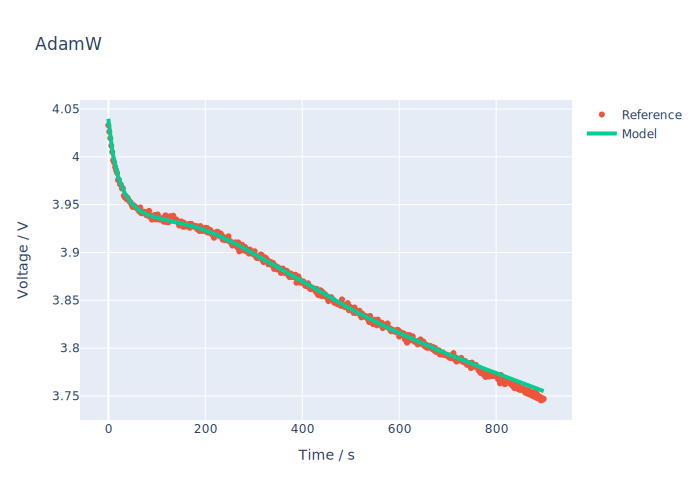

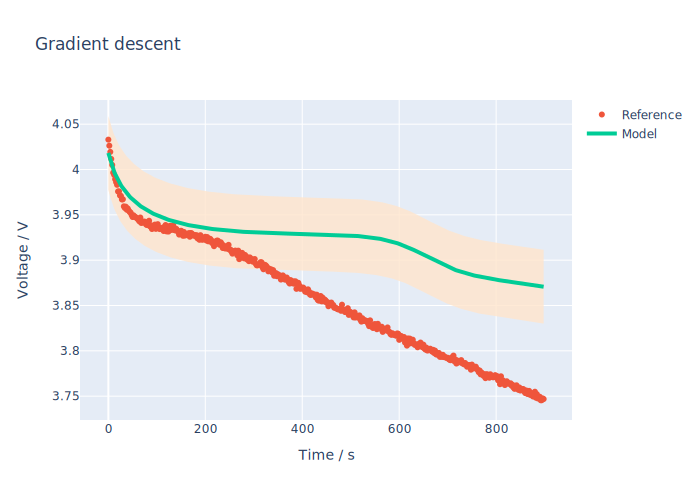

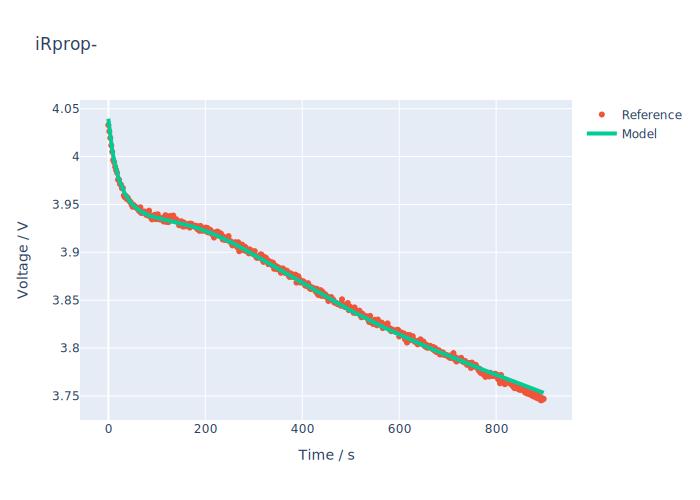

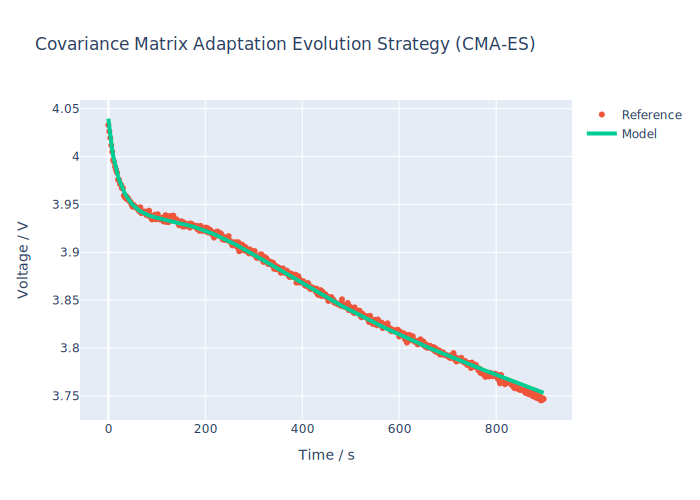

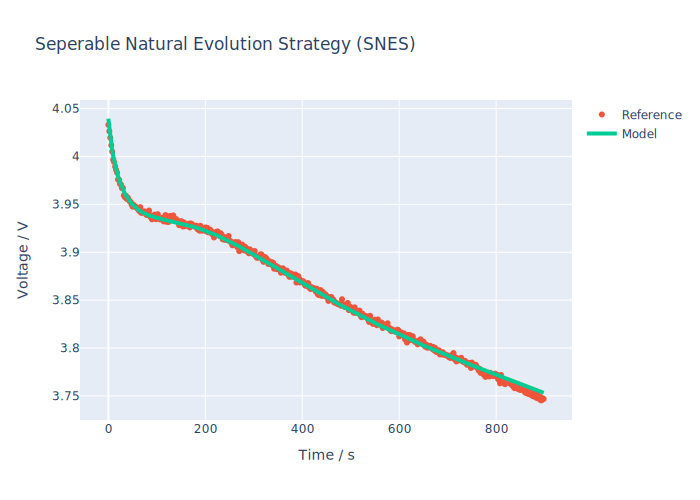

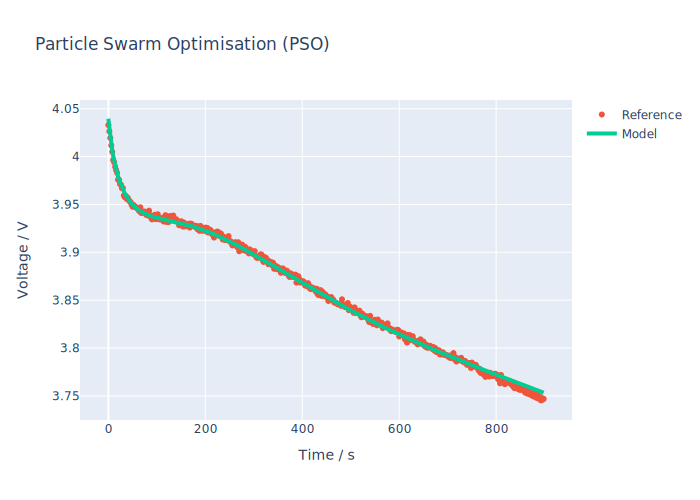

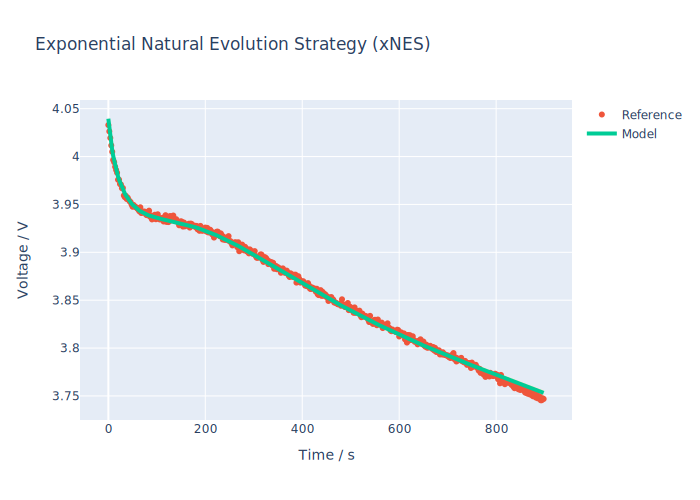

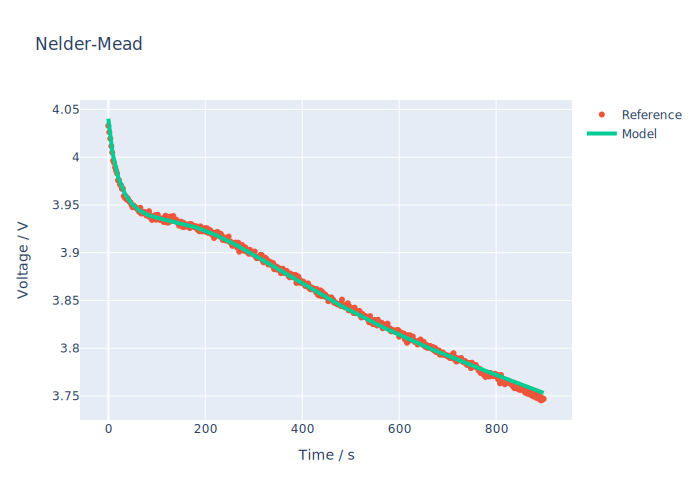

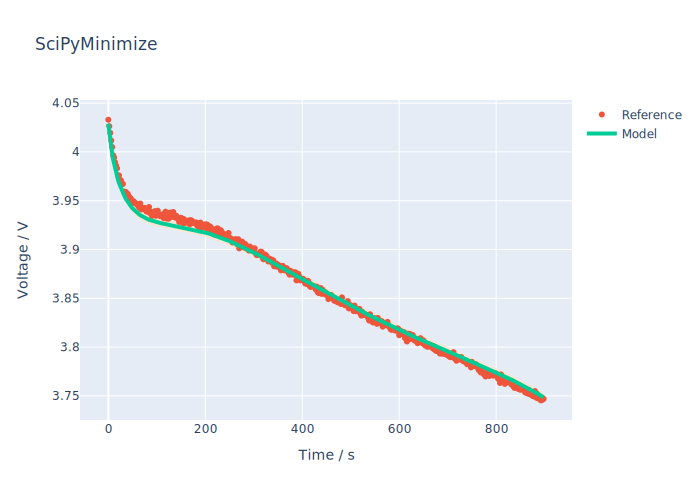

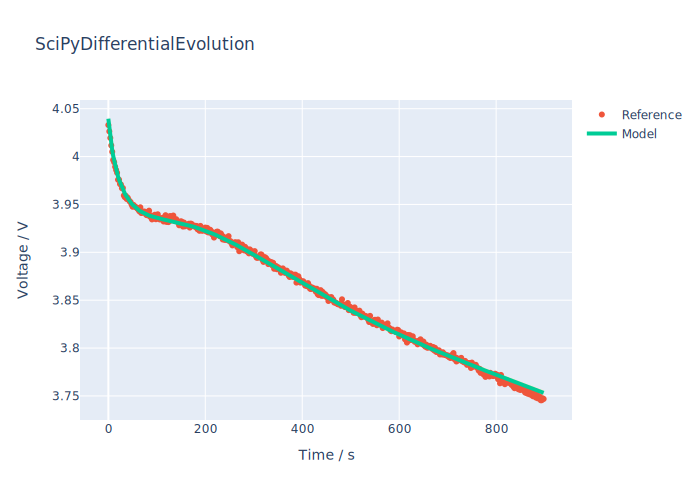

In [13]:
for optim, x in zip(optims, xs):
    pybop.quick_plot(optim.cost.problem, parameter_values=x, title=optim.name())

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

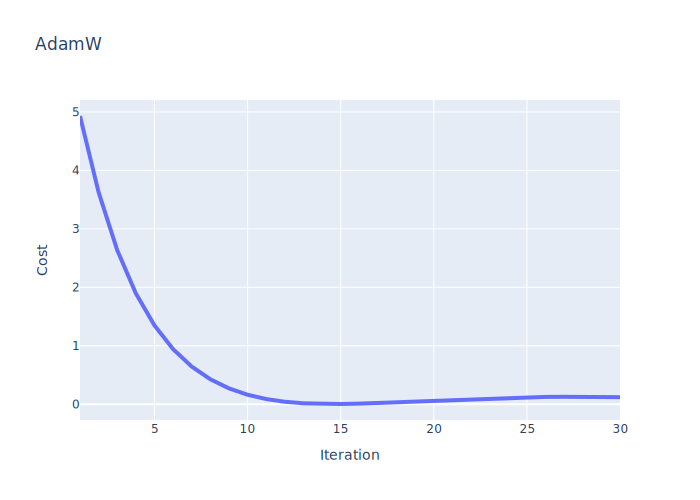

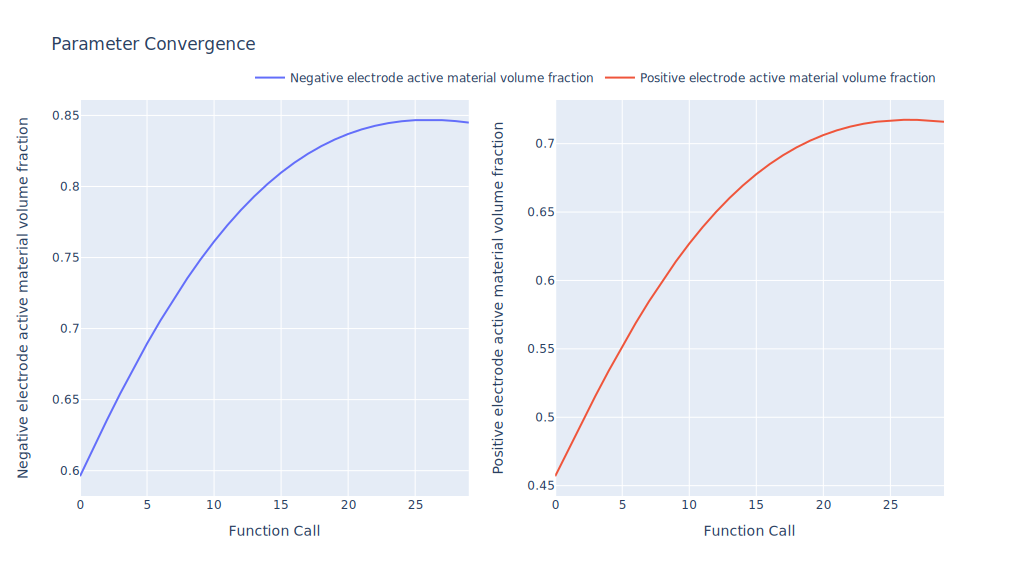

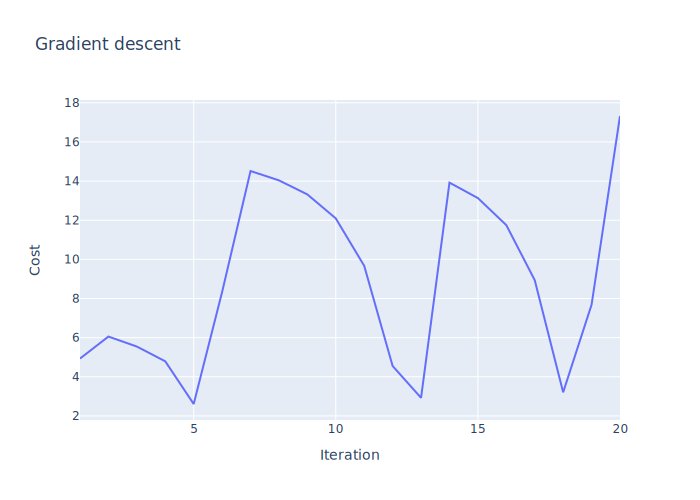

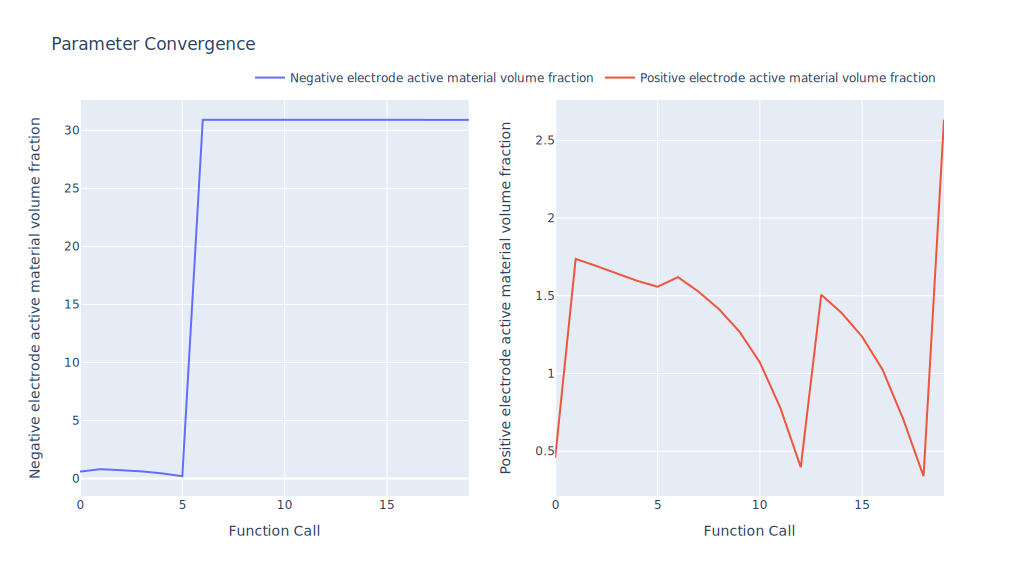

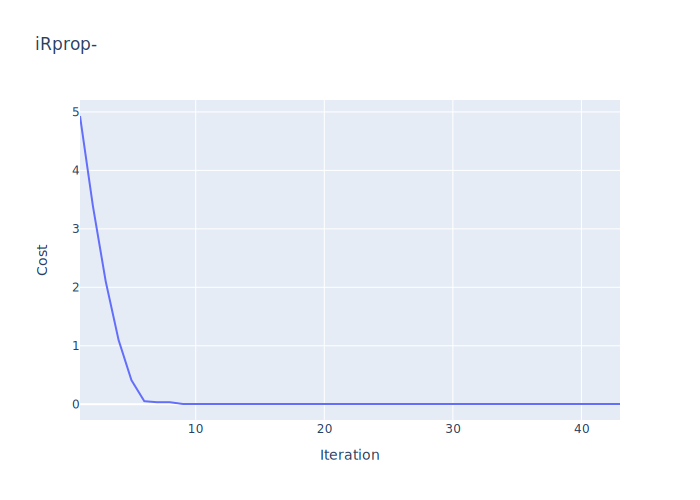

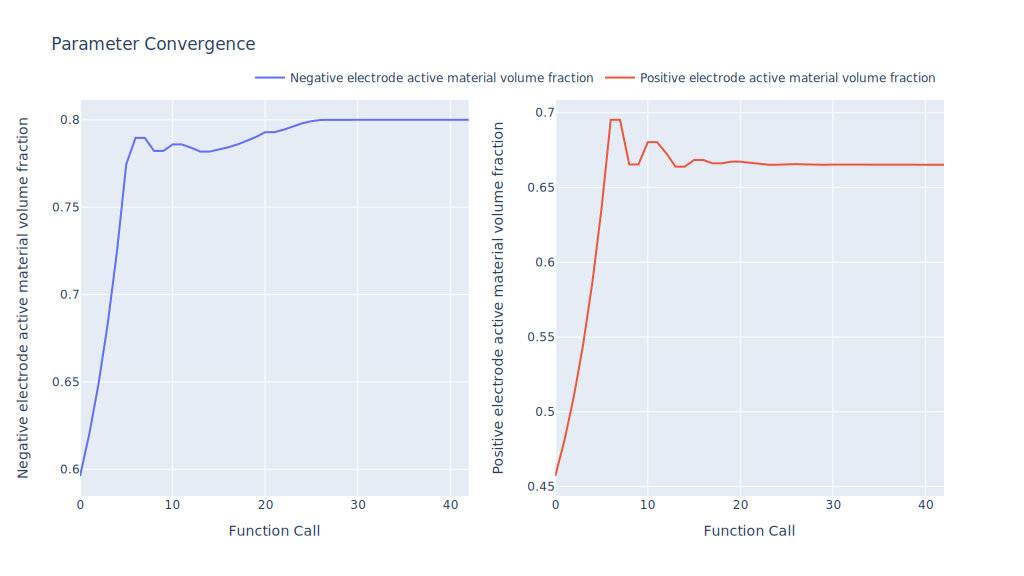

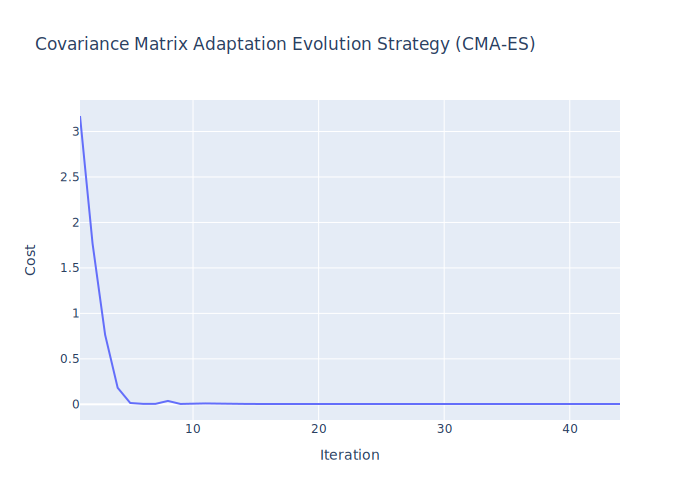

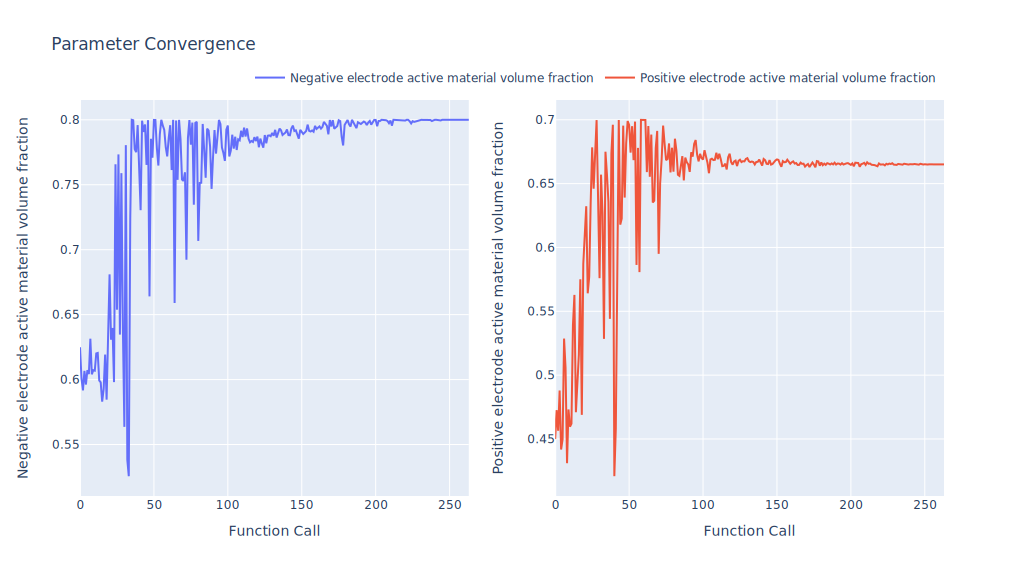

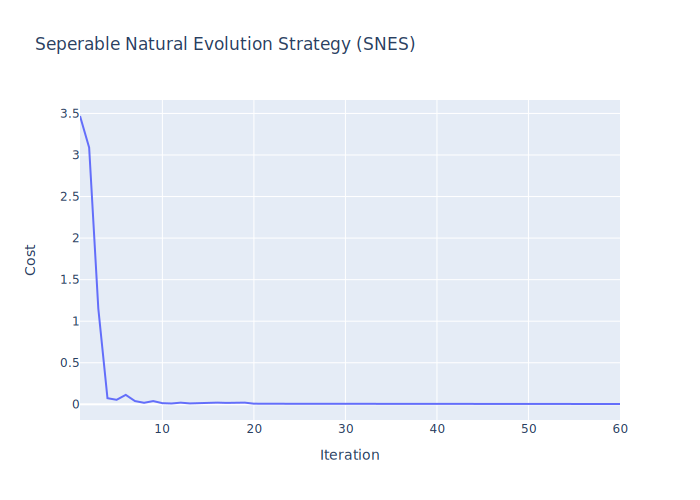

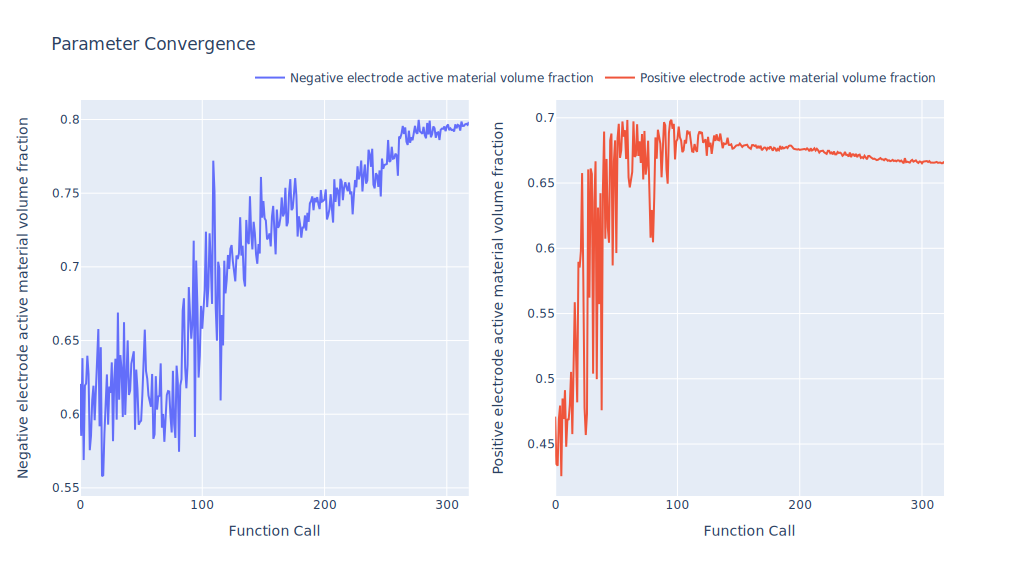

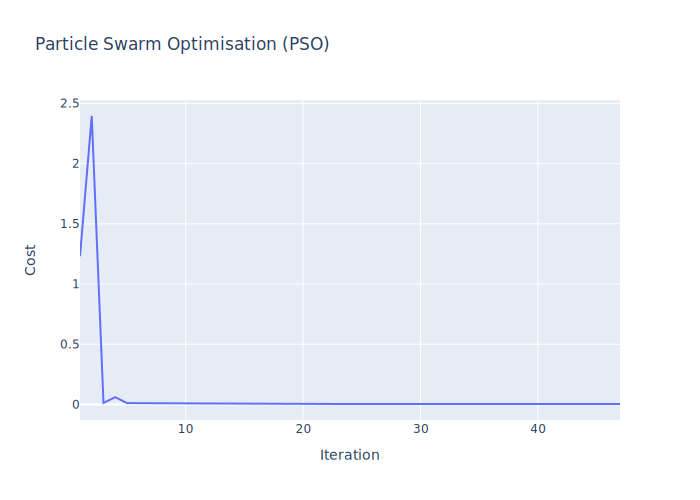

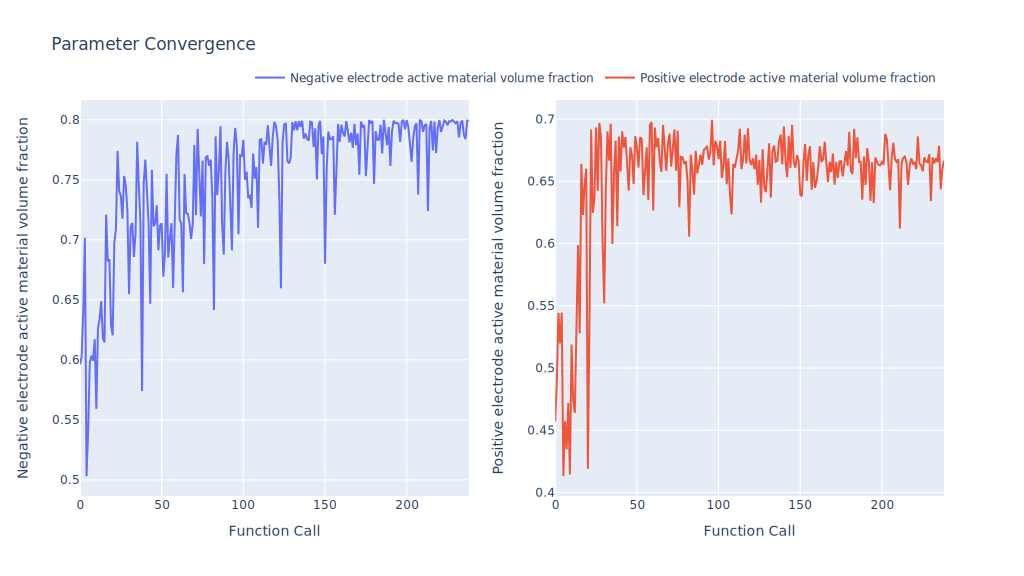

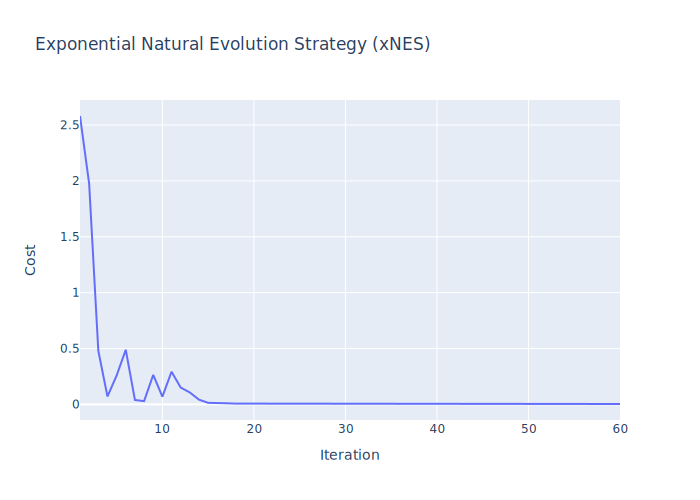

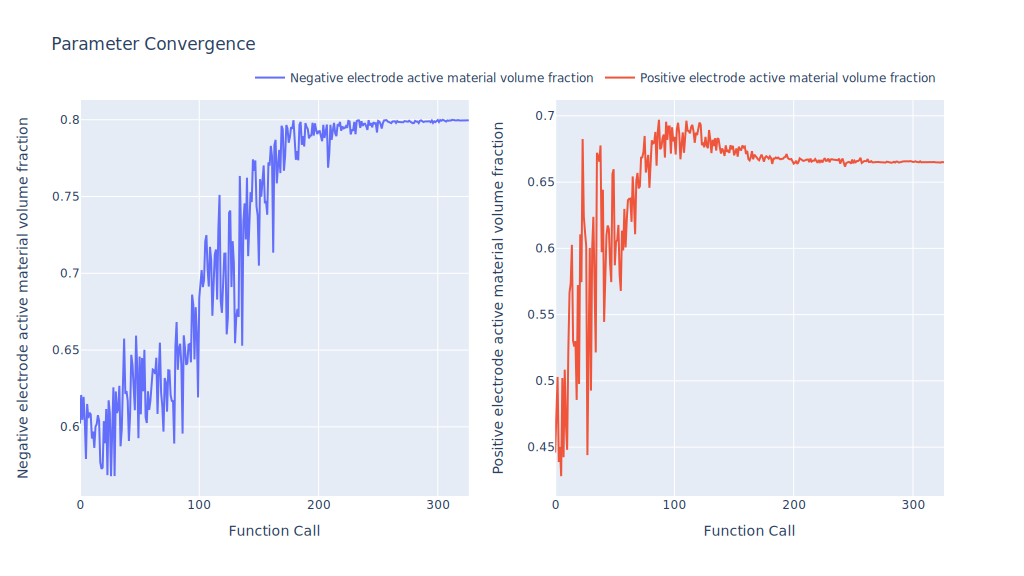

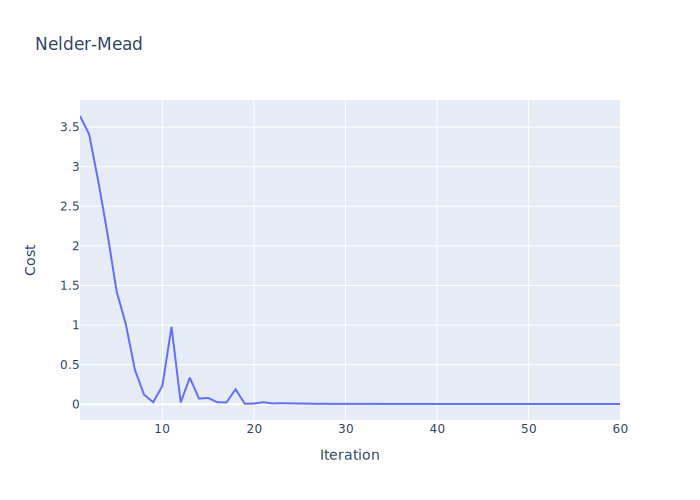

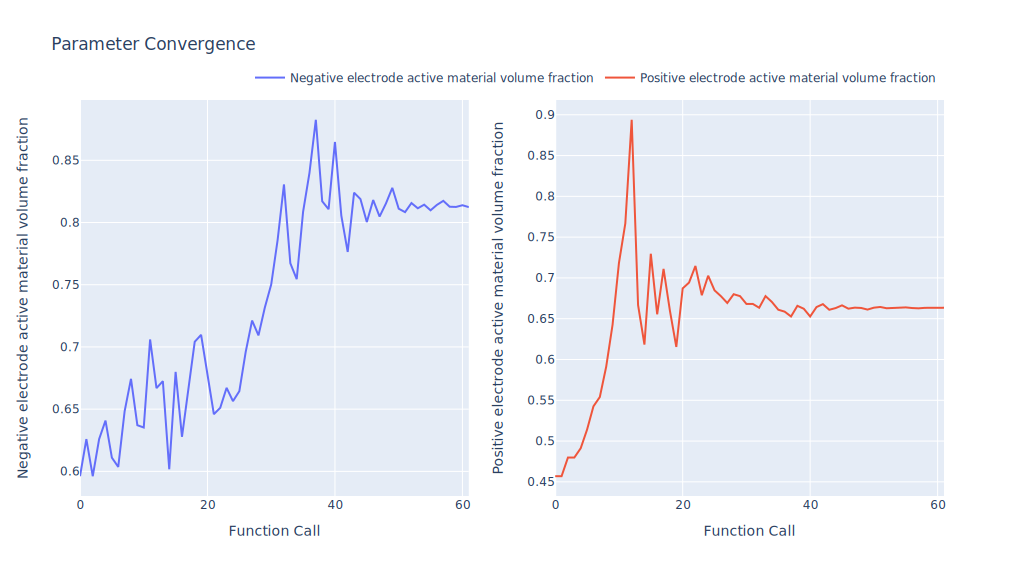

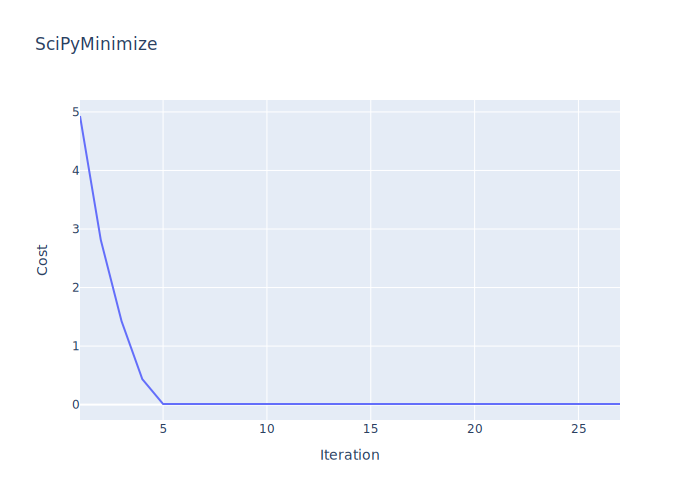

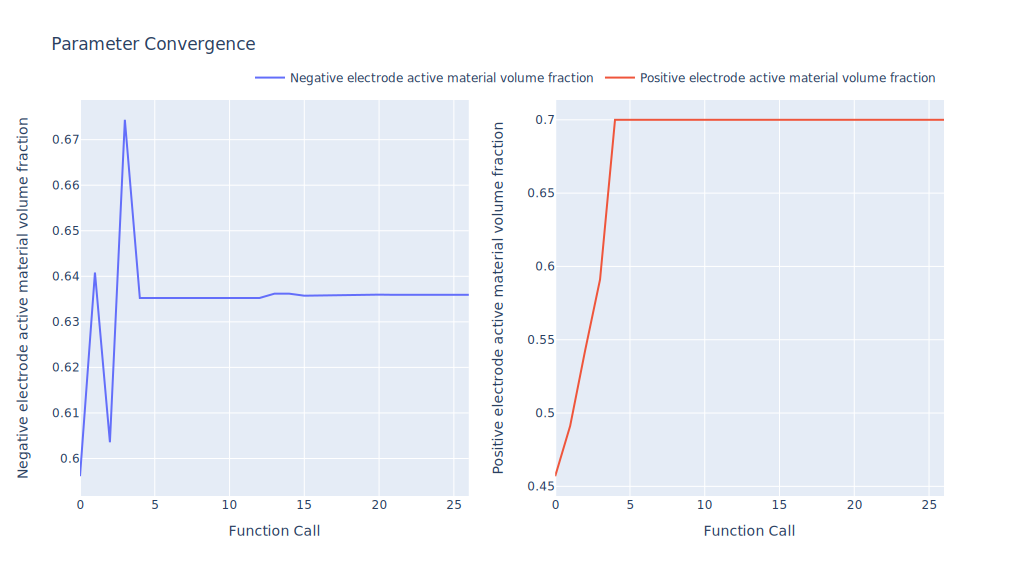

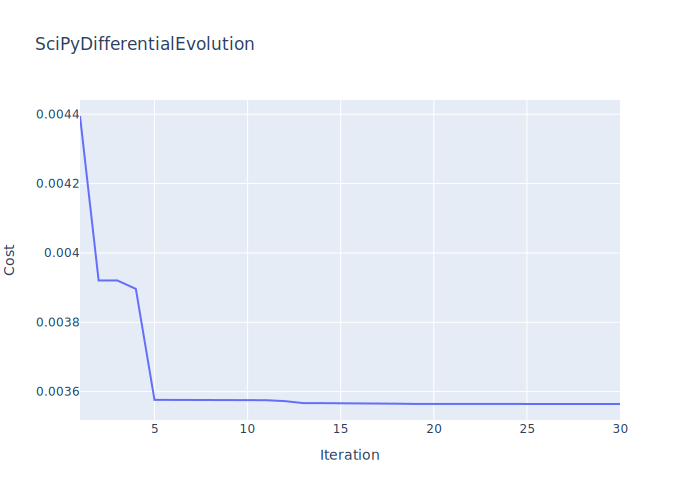

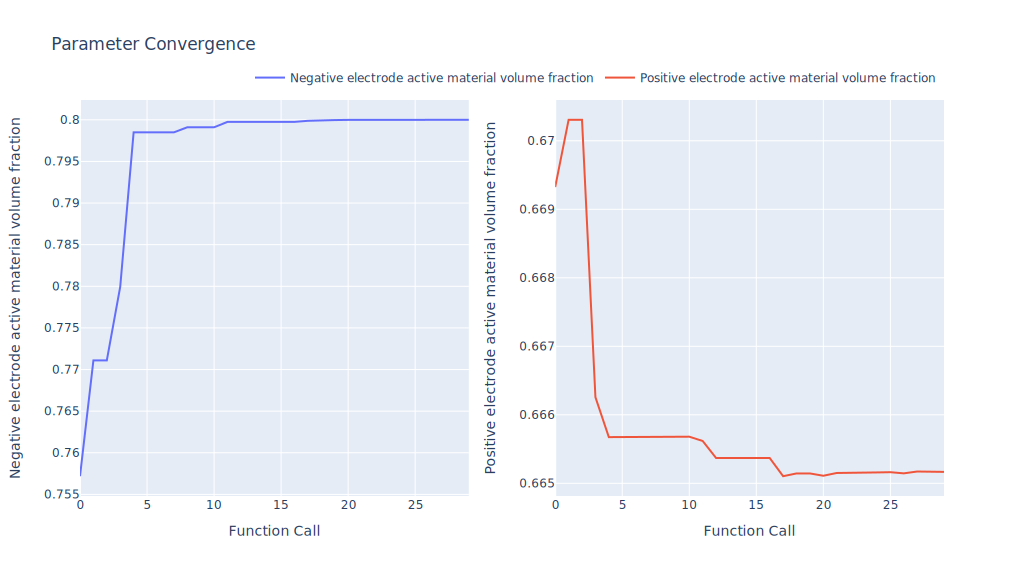

In [14]:
for optim in optims:
    pybop.plot_convergence(optim, title=optim.name())
    pybop.plot_parameters(optim)

### Cost Landscape

Finally, we can visualise the cost landscape and the path taken by the optimiser. This should give us additional insight into whether the negative electrode volume fraction is observable or not. For an observable parameter, the cost landscape needs to have a clear minimum with respect to the parameter in question. More clearly, the parameter value has to have an effect on the cost function.

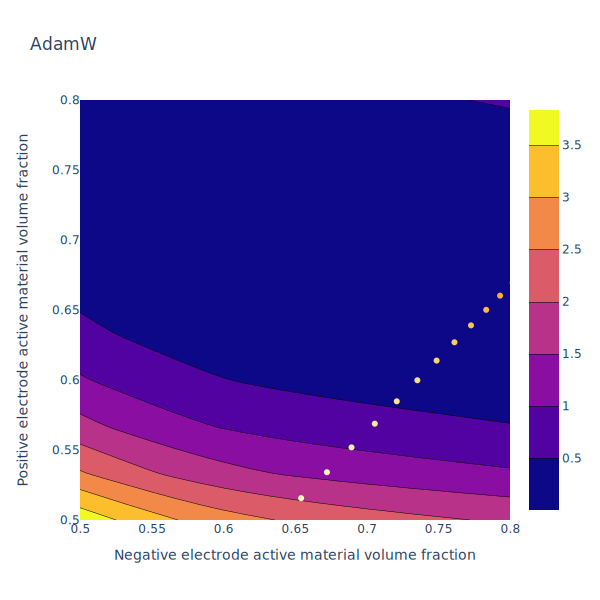

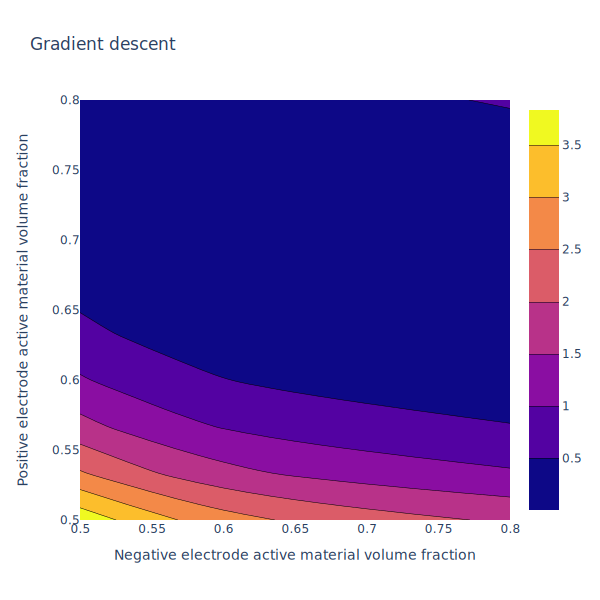

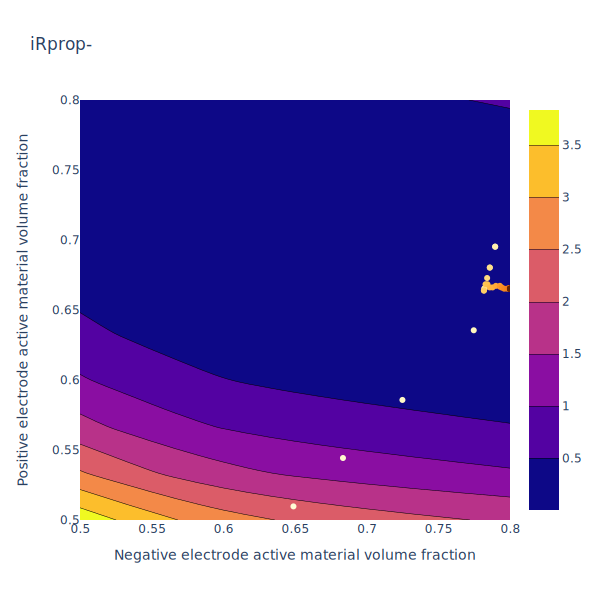

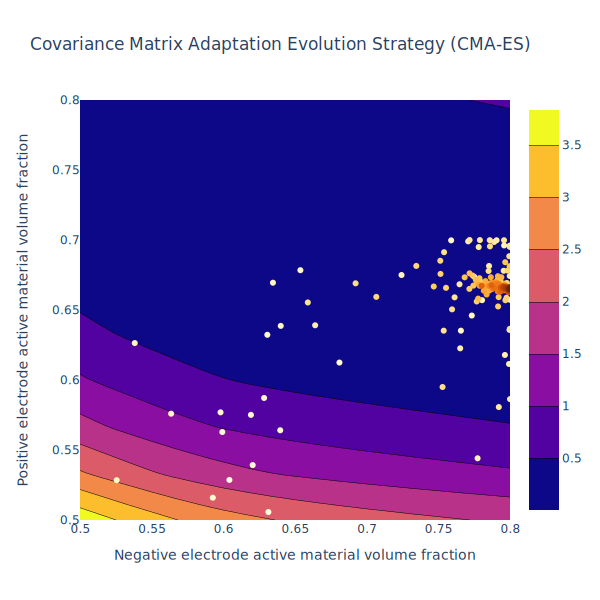

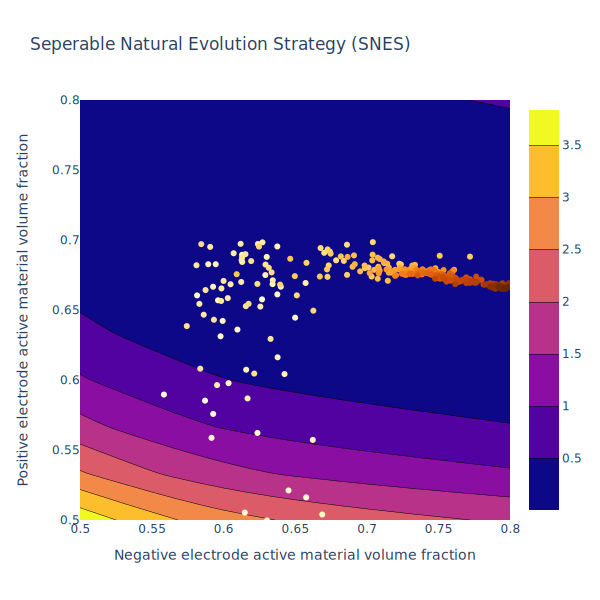

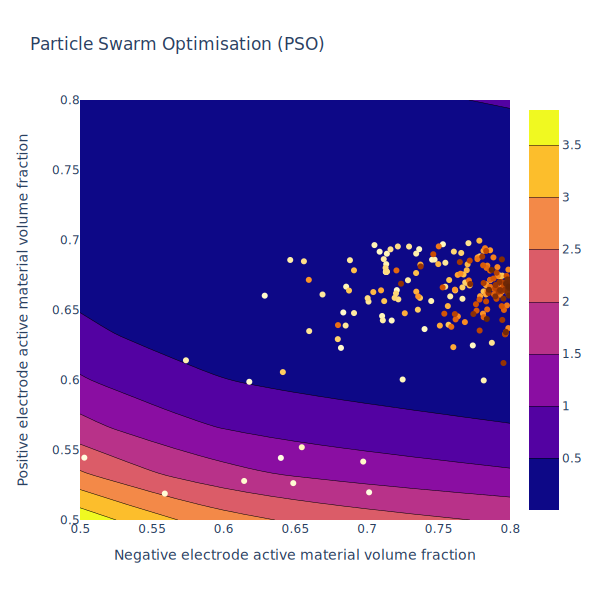

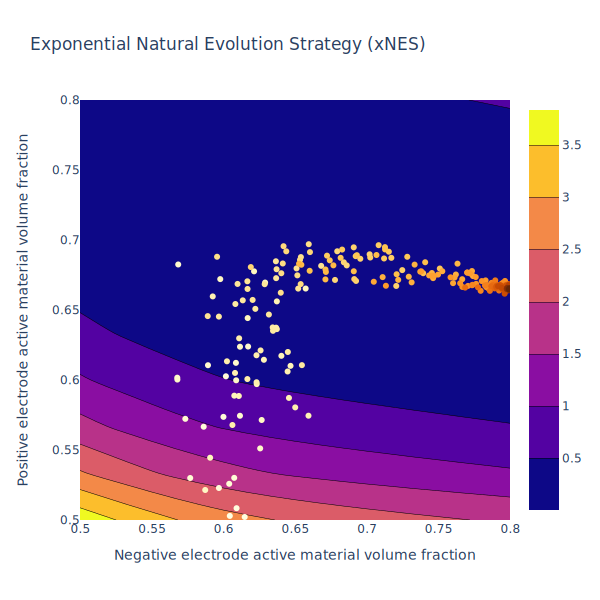

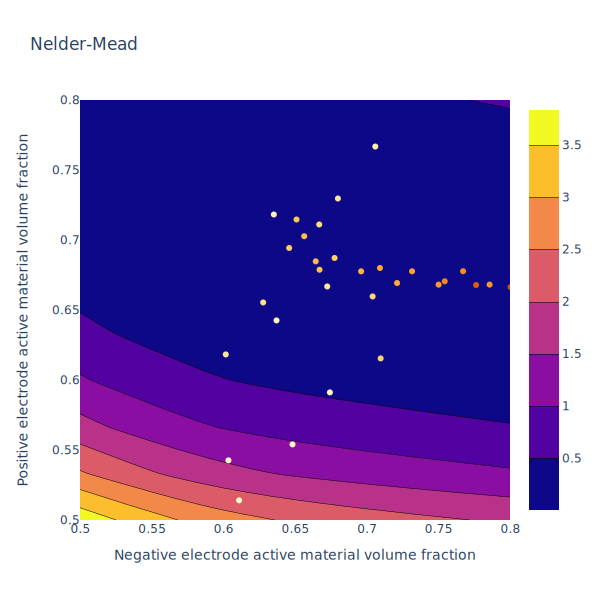

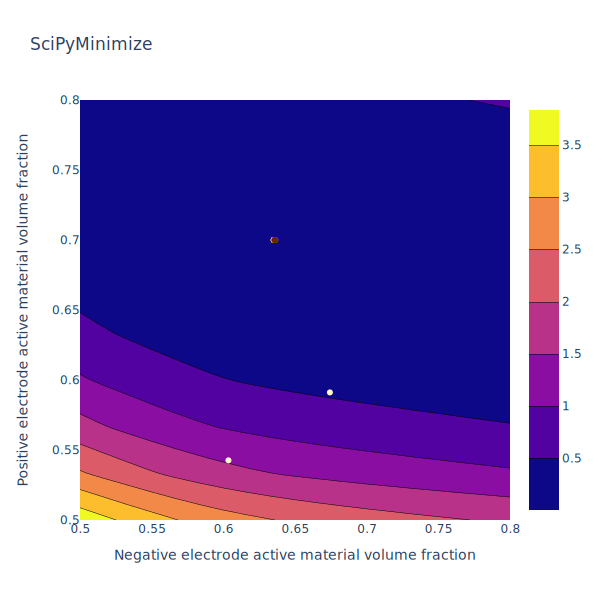

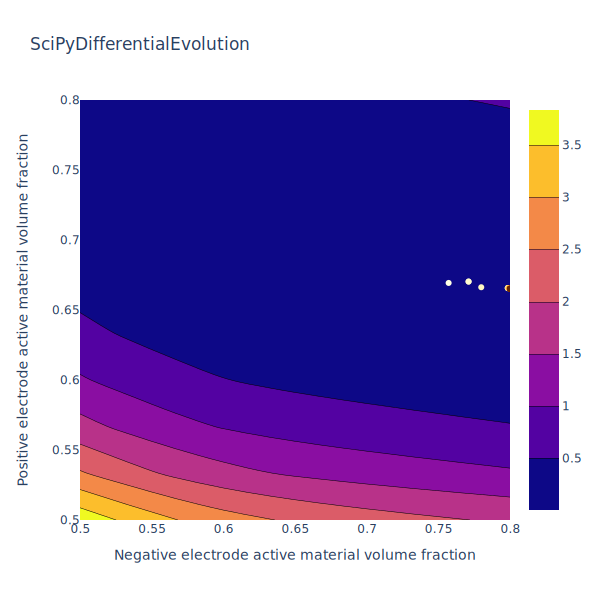

In [15]:
# Plot the cost landscape with optimisation path and updated bounds
bounds = np.array([[0.5, 0.8], [0.55, 0.8]])
for optim in optims:
    pybop.plot2d(optim, bounds=bounds, steps=10, title=optim.name())

Given the synthetic data and corresponding system excitation, the observability of the negative electrode active material fraction is quite low. As such, we would need to excite the system in a different way or observe a different signal to acquire a unique value.

### Conclusion

This notebook illustrates how to perform parameter estimation using PyBOP, across both gradient and non-gradient-based optimisers. 